# WhatsApp Group Chat Analysis 

In this analysis, we will use a group chat document extracted from my personal WhatsApp account. Lets analyze stuffs 

In [8]:
import regex
import pandas as pd 
import numpy as np  
import emoji
import plotly.express as px 
from collections import Counter
import matplotlib.pyplot as plt 
from os import path 
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import re
%matplotlib inline 

Although, the data is ready to use we still need to change the format of the date and time of messages which can be done easily. For this I will define a function that can detect whether each line starts with a date as it states that it is a unique message:

In [7]:
def startWithDateAndTime(s) :
    pattern = '^([0-9]+)(\/)([0-9]+)(\/)([0-9]+), ([0-9]+):([0-9]+)[ ]?(AM|PM|am|pm)? -'
    result = re.match(pattern, s)
    if result :
        return True 
    return False 

Now I will create a function to extract the usernames in the chats as Authors

In [4]:
def FindAuthor(s):
    s = s.split(":")
    if len(s) == 2:
        return True 
    else:
        return False 

Now, I will create a function to separate all the information from each other so that we could easily use the information as a pandas dataframe:

In [5]:
def getDataPoint(line):
    splitLine = line.split('-')
    dateTime = splitLine[0]
    date, time = dateTime.split(',')
    message = ' '.join(splitLine[1:])
    if FindAuthor(message):
        splitMessage = message.split(': ')
        author = splitMessage[0]
        message = ' '.join(splitMessage[1:])
    else : 
        author = None 

    return date, time, author, message

## Loading Data 

In [10]:
parsedData = []
conversation = 'chat.txt'
with open(conversation, encoding= 'utf-8') as fp:
    fp.readline() 
    # skipping first line because in the text file thats states information that we dont need (eg.encription)
    messageBuffer = []
    date, time, author = None, None, None
    while True :
        line = fp.readline()
        if not line :
            break
        line = line.strip()
        if startWithDateAndTime(line):
            if len(messageBuffer) >0 :
                parsedData.append([date,time,author,' '.join(messageBuffer)])
            messageBuffer.clear()
            date, time, author, message = getDataPoint(line)
            messageBuffer.append(message)
        else:
            messageBuffer.append(line)
            

## Now we will put the data into dataframe 

In [12]:
df = pd.DataFrame(parsedData, columns = ['Date','Time','Author','Message'])
df["Date"] = pd.to_datetime(df["Date"])
df.head(10)

,Date,Time,Author,Message
0,2021-06-01,13:04,None,"Ahona Rj created group ""Shadhin Hobar Gaan """
1,2021-06-01,13:04,None,Ahona Rj added you
2,2021-06-01,13:06,None,Maimun Band Flickering Flame changed the subj...
3,2021-06-01,13:06,None,Maimun Band Flickering Flame changed this gro...
4,2021-06-01,13:04,Maimun Band Flickering Flame,🎈
5,2021-06-01,13:05,Ahona Rj,💭
6,2021-06-01,13:07,Ahona Rj,<Media omitted>
7,2021-06-01,13:07,Ahona Rj,Meeting minutes
8,2021-06-01,13:10,Maimun Band Flickering Flame,Thank you
9,2021-06-01,13:10,Ahona Rj,👍


## Now that we have the dataframe ready somewhat, we can start analysis. First, getting the authors 

In [13]:
df.Author.unique()

array([None, ' Maimun Band Flickering Flame', ' Ahona Rj', ' Farsim',
       ' Aziz Shadhin', ' Jasiya'], dtype=object)

I will first create a function which will split the text and other media files from each other including emojis:

In [27]:
media_messages = df[df['Message'] == '<Media omitted>'].shape[0]
print(media_messages)
def split_count(text):

    emoji_list = []
    
    data = regex.findall(r'/(\u00a9|\u00ae|[\u2000-\u3300]|\ud83c[\ud000-\udfff]|\ud83d[\ud000-\udfff]|\ud83e[\ud000-\udfff])/', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)

    return emoji_list

df["emoji"] = df["Message"].apply(split_count)
emojis = sum(df['emoji'].str.len())
print(emojis)
URLPATTERN = r'(https?://\S+)'
df['urlcount'] = df.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()
links = np.sum(df.urlcount)
print("Data science Community")
print("Messages:",df.count(0)[4])
print("Media:",media_messages)
print("Emojis:",emojis)
print("Links:",links)

18
0
Data science Community
Messages: 538
Media: 18
Emojis: 0
Links: 12


In [48]:
# extracting message from media msg

media_messages_df = df[df['Message'] == '<Media omitted>']
messages_df = df.drop(media_messages_df.index)

messages_df['Letter_Count'] = messages_df['Message'].apply(lambda s : len(s))
messages_df['Word_Count'] = messages_df['Message'].apply(lambda s : len(s.split(' ')))
messages_df["MessageCount"] = 1 

messages_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 520 entries, 0 to 537
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          520 non-null    datetime64[ns]
 1   Time          520 non-null    object        
 2   Author        489 non-null    object        
 3   Message       520 non-null    object        
 4   emoji         520 non-null    object        
 5   urlcount      520 non-null    int64         
 6   Letter_Count  520 non-null    int64         
 7   Word_Count    520 non-null    int64         
 8   MessageCount  520 non-null    int64         
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 40.6+ KB


## Individual user messages 

In [53]:
l = [' Maimun Band Flickering Flame', ' Ahona Rj', ' Farsim', ' Aziz Shadhin', ' Jasiya']

for i in range(len(l)):

    #filtering out msgs of particular user 
    req_df = messages_df[messages_df["Author"] == l[i]]

    #req_df will contain messages of only one particular user 
    print(f'Stats of {l[i]} - ')
    ## shape will print number of rows which indirectly means the number of messages
    print('Messages sent', req_df.shape[0])
    # words per message of particular user 
    words_per_message = (np.sum(req_df['Word_Count']))/req_df.shape[0]
    print('Words per message:', words_per_message)

    #media consists of media messages 
    media = media_messages_df[media_messages_df['Author'] == l[i]].shape[0]
    print('Media Messages Sent:', media)

    # emojis conists of total emojis
    emojis = sum(req_df['emoji'].str.len())
    print('Emojis Sent', emojis)
    #links consist of total links
    links = sum(req_df["urlcount"])   
    print('Links Sent', links)   
    print() # this print func is amazing, grouping all the prints 

Stats of  Maimun Band Flickering Flame - 
Messages sent 187
Words per message: 3.625668449197861
Media Messages Sent: 1
Emojis Sent 0
Links Sent 0

Stats of  Ahona Rj - 
Messages sent 136
Words per message: 3.2794117647058822
Media Messages Sent: 6
Emojis Sent 0
Links Sent 0

Stats of  Farsim - 
Messages sent 86
Words per message: 13.348837209302326
Media Messages Sent: 0
Emojis Sent 0
Links Sent 1

Stats of  Aziz Shadhin - 
Messages sent 77
Words per message: 5.766233766233766
Media Messages Sent: 11
Emojis Sent 0
Links Sent 0

Stats of  Jasiya - 
Messages sent 3
Words per message: 6.0
Media Messages Sent: 0
Emojis Sent 0
Links Sent 0



### Emojis 
Although we are seeing that none of us sent emojis, this code is helpful to learn 


In [54]:
total_emojis_list = list(a for b in messages_df.emoji for a in b)

emoji_dict = dict(Counter(total_emojis_list))

emoji_dict = sorted(emoji_dict.items(), key = lambda x : x[1], reverse= True) # interesting sort function

for i in emoji_dict:
    print(i)



## WordCloud 

We will take a look at a wordcloud on overall messages. Then we will see them for each user 

There are 16642 words in all the messages.


<function matplotlib.pyplot.show(close=None, block=None)>

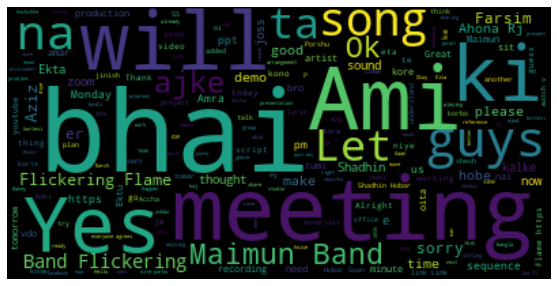

In [55]:
text = " ".join(review for review in messages_df.Message)
print("There are {} words in all the messages.".format(len(text)))

stopwords = set(STOPWORDS) # this will be filtered out

#generate a word cloud image 
wordcloud = WordCloud(stopwords=stopwords, background_color="black").generate(text)

plt.figure(figsize = (10,5))
plt.imshow(wordcloud, interpolation= 'bilinear')
plt.axis("off")
plt.show


Author Name:  Maimun Band Flickering Flame


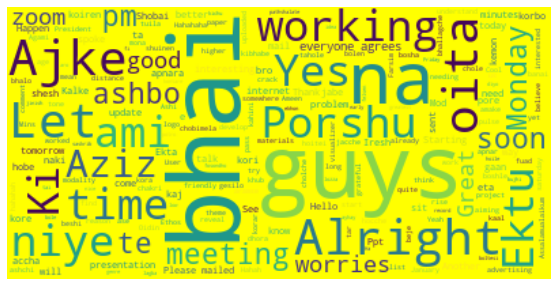

Author Name:  Ahona Rj


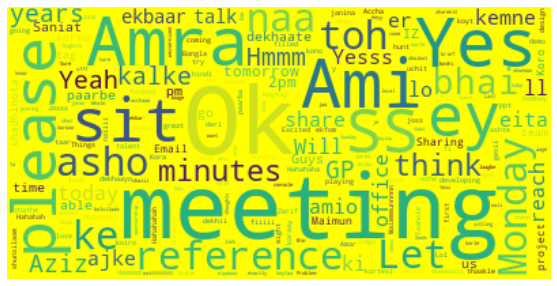

Author Name:  Farsim


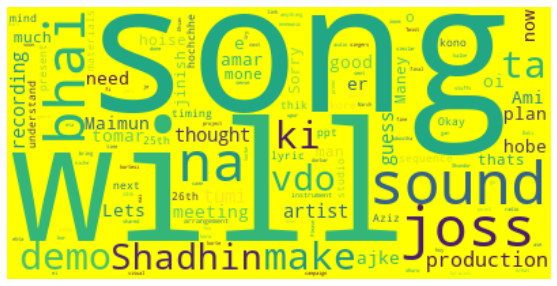

Author Name:  Aziz Shadhin


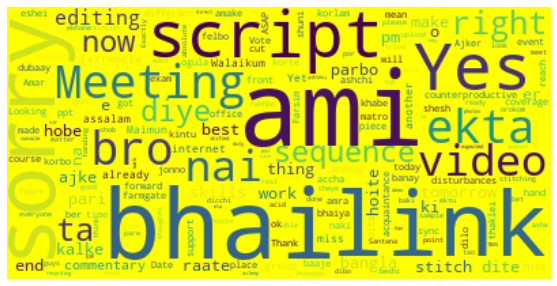

Author Name:  Jasiya


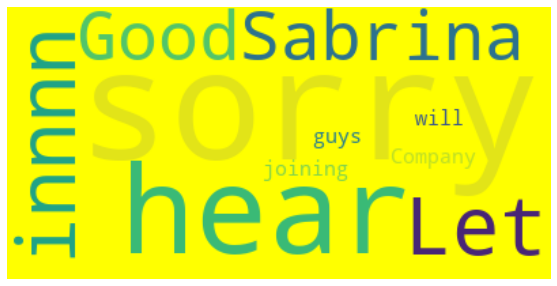

In [69]:
l = [' Maimun Band Flickering Flame', ' Ahona Rj', ' Farsim', ' Aziz Shadhin', ' Jasiya']

for i in range(len(l)):



    dummy_df = messages_df[messages_df['Author'] == l[i]]
    text = " ".join(review for review in dummy_df.Message)
    stopwords = set(STOPWORDS)

    print('Author Name:', l[i])
    wordcloud = WordCloud(stopwords=stopwords, background_color="yellow").generate(text)


   

    plt.figure( figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()